<a href="https://colab.research.google.com/github/aneesh98/Real-Or-Not/blob/master/RealOrNot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!chmod +x kagglesetup.sh
!./kagglesetup.sh c nlp-getting-started

  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 37.2MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 56.7MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 61.6MB/s]
test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:
train_file_name = 'train.csv'
df_train = pd.read_csv(train_file_name)
train_column_names = df_train.columns.values
print(df_train['keyword'].isnull().value_counts())
print(df_train['location'].isnull().value_counts())


False    7552
True       61
Name: keyword, dtype: int64
False    5080
True     2533
Name: location, dtype: int64


In [0]:
df_train[~(df_train['location'].isnull())]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0


Looking at the variation in the lengths of the tweets.
The histogram shows most of the tweets have length of 125 words.

Text(0.5, 1.0, 'Non Disaster Tweets')

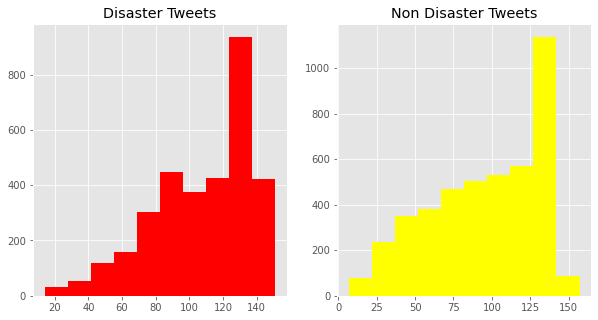

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
actual_disasters = df_train.loc[df_train['target'] == 1, 'text']
not_disasters = df_train.loc[df_train['target'] == 0, 'text']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
num_words_ad = actual_disasters.str.len()
ax1.hist(num_words_ad, color = 'red')
ax1.set_title('Disaster Tweets')
num_words_nd = not_disasters.str.len()
ax2.hist(num_words_nd, color = 'yellow')
ax2.set_title('Non Disaster Tweets')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


(array([ 117.,  460.,  898., 1246., 1320., 1439., 1095.,  688.,  287.,
          63.]),
 array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28., 31.]),
 <a list of 10 Patch objects>)

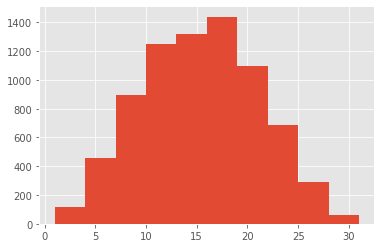

In [0]:
nltk.download('punkt')
default_st = nltk.word_tokenize
tokenized_tweets = df_train['text'].map(lambda x: x.split()).map(lambda x: len(x))
plt.hist(tokenized_tweets)

In [0]:
first_text = actual_disasters[0]
import nltk
try:
  print(nltk.pos_tag(first_text.split()))
except LookupError:
  nltk.download('averaged_perceptron_tagger')
  print(nltk.pos_tag(first_text.split()))

[('Our', 'PRP$'), ('Deeds', 'NNS'), ('are', 'VBP'), ('the', 'DT'), ('Reason', 'NNP'), ('of', 'IN'), ('this', 'DT'), ('#earthquake', 'NN'), ('May', 'NNP'), ('ALLAH', 'NNP'), ('Forgive', 'NNP'), ('us', 'PRP'), ('all', 'DT')]


In [0]:
pos_tagged_sent = nltk.pos_tag(first_text.split())
grammar = '''
            NP: {<DT>?<JJ>?<NN.*>}
            ADJP: {<JJ>}
            ADVP: {<RB.*>}
            PP: {<IN>}
            VP: {<MD>?<VB.*>+}
          '''
rp = nltk.RegexpParser(grammar)
shallow_parsed_sent = rp.parse(pos_tagged_sent)
print(shallow_parsed_sent)

(S
  Our/PRP$
  (NP Deeds/NNS)
  (VP are/VBP)
  (NP the/DT Reason/NNP)
  (PP of/IN)
  (NP this/DT #earthquake/NN)
  (NP May/NNP)
  (NP ALLAH/NNP)
  (NP Forgive/NNP)
  us/PRP
  all/DT)


In [0]:
import string
from collections import defaultdict

special_chars = string.punctuation
actual_disasters_list = actual_disasters.to_list()
not_disasters_list = not_disasters.to_list()
all_texts = actual_disasters_list + not_disasters_list
all_texts = [x.split() for x in all_texts]
len(all_texts), len(actual_disasters_list) + len(not_disasters_list)

(7613, 7613)

In [0]:
 def get_dict(lists):
  dic = defaultdict(int)
  for j in lists:
    for i in j:
      if i in special_chars:
        dic[i] += 1
  return dic

**Looking at the special characters present and their frequency.**

<BarContainer object of 29 artists>

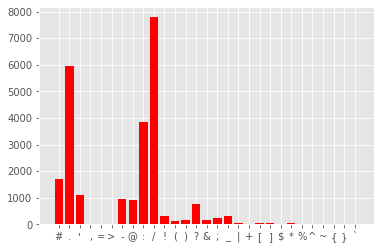

In [0]:
dic_ad = get_dict(actual_disasters)
dic_nd = get_dict(not_disasters)
x_ad, y_ad = zip(*dic_ad.items())
plt.bar(x_ad, y_ad, color = 'red')


In [0]:
import re 
string = 'Go To https://www.mysite.com'
pattern = 'https://\S+|www\.\S+'
res = re.sub(pattern, '', string, re.IGNORECASE)
print(res)

Go To 


Looking for the presence of stopwords and their counts.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<BarContainer object of 10 artists>

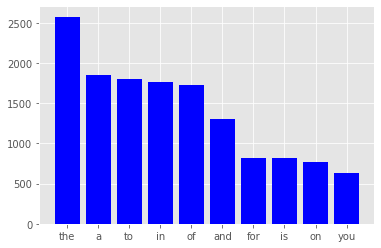

In [0]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=set(stopwords.words('english'))
word_count = defaultdict(int)
for tweets in all_texts:
  for word in tweets:
    if word in stop:
      word_count[word] += 1
top=sorted(word_count.items(), key=lambda x:x[1],reverse=True)[:10]
words, counts = zip(*top)
plt.bar(words, counts, color = 'blue')

CHECKING AND REMOVING URLS

In [0]:
### CHECK FOR URLS
import re
def check_urls(texts):
  linked_tweets = []
  pattern1 = 'http://\S+|www\.\S+'
  pattern2 = 'https://\S+|www\.\S+'
  for x in texts:
    if re.search(pattern1, x, re.IGNORECASE)!=None or  re.search(pattern2, x, re.IGNORECASE) != None:
      linked_tweets.append(x)
  return linked_tweets
linked_tweets = check_urls(not_disasters_list)
print(len(linked_tweets))

1799


Finding tweets with hypertext

In [0]:
pattern = r"<.*>"
linked_tweets = []
for x in actual_disasters_list:
  if re.search(pattern, x, re.IGNORECASE)!=None:
    linked_tweets.append(x)
print(len(linked_tweets))

0


In [0]:
### REMOVE URLS ###
def remove_urls(x):
  pattern1 = r'http?://\S+|www\.\S+'
  pattern2 = r'https?://\S+|www\.\S+'
  res = re.sub(pattern1, '', x, re.IGNORECASE)
  res = re.sub(pattern2, '', x, re.IGNORECASE)
  return res

df_train['text'] = df_train['text'].map(lambda x: remove_urls(x))
linked_tweets = check_urls(df_train['text'].to_list())
print(len(linked_tweets))
### REMOVE HTML TAGS ###
def remove_tags(x):
  pass

25


In [0]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [0]:
df_train['text']=df_train['text'].apply(lambda x: remove_emoji(x))

In [0]:
def remove_punct(text):
  pattern = r'[^a-zA-Z0-9\s]'
  text = re.sub(pattern, '', text)
  return text

df_train['text'] = df_train['text'].map(lambda x: 
                                        remove_punct(x))

In [0]:
dic = get_dict(df_train['text'].to_list())

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['text'])


Using TensorFlow backend.


In [0]:
def remove_stopwords(text):
  tokens = text.split()
  filtered_tokens = [token for token in tokens
                     if token.lower() not in stop]
  filtered_text = ' '.join(filtered_tokens)
  return filtered_text

test = "The a again go into hell"
remove_stopwords(test)

'go hell'

In [0]:
df_train['text'] = df_train['text'].map(lambda x: remove_stopwords(x))

In [0]:
sequences = tokenizer.texts_to_sequences(df_train['text'])


In [0]:
len(tokenizer.word_index.values())

17797

In [0]:
maxlen = max([len(x) for x in sequences])
padded_sequences = pad_sequences(sequences, maxlen = maxlen)
labels = df_train['target'].to_list()


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size = 0.2, stratify = labels)
x_train, x_test, y_train, y_test = np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)

In [0]:
input_dim = len(tokenizer.word_index.values())
embedding_dim = 64
optimizer = 'adam'
loss = 'binary_crossentropy'
metrics = ['acc']

In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-04-23 09:11:21--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-04-23 09:11:21--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-04-23 09:11:22--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
!wget "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-04-23 09:31:36--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.233.69
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.233.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  89.8MB/s    in 19s     

2020-04-23 09:31:55 (81.8 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
from gensim.models.keyedvectors import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format(
          "GoogleNews-vectors-negative300.bin.gz", binary = True,
          limit = 200000
      )


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


300

The following Callbacks where used during training:


*   **EarlyStopping**: Stops the training process if the specified metric stops improving 
*   **ReduceLROnPlateau**: Reduce the learning rate when the metric has stopped improving.



In [0]:
## BASE LINE MODEL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding, LSTM, SimpleRNN, Bidirectional, Dropout, BatchNormalization
import os
import tensorflow.keras 
class MyModel:
  def __init__(self):
    pass
  def Model(self, embedding_type = 'custom',
            loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'], input_dim = 30, 
            embedding_dim = 64, tokenizer = None):
    model = Sequential()
    
    if embedding_type == 'custom':
      model.add(Embedding(input_dim + 1, embedding_dim))
    elif embedding_type == 'glove':
      embeddings_index = {}
      f = open('glove.6B.100d.txt')
      for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype = 'float32')
        embeddings_index[word] = coefs
      f.close()
      word_index = tokenizer.word_index
      embedding_dim = 100
      embedding_matrix = np.zeros((input_dim + 1, embedding_dim))
      for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word) 
        if i < input_dim + 1:
          if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector 
      model.add(Embedding(input_dim + 1, embedding_dim))
      model.layers[0].set_weights([embedding_matrix])
      model.layers[0].trainable = False
    elif embedding_type == 'word2vec':
      from gensim.models.keyedvectors import KeyedVectors
      word_vectors = KeyedVectors.load_word2vec_format(
          "GoogleNews-vectors-negative300.bin.gz", binary = True
      )
      word_index = tokenizer.word_index
      embedding_dim = 300
      embedding_matrix = np.zeros((input_dim + 1, embedding_dim))
      for word, i in word_index.items():
        try:
          embedding_vector = word_vectors[word] 
        except KeyError:
          embedding_vector = np.zeros((embedding_dim,))
        if i < input_dim + 1:
          if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector 
      model.add(Embedding(input_dim + 1, embedding_dim))
      model.layers[0].set_weights([embedding_matrix])
      model.layers[0].trainable = False
    model.add(Bidirectional(LSTM(embedding_dim, recurrent_dropout = 0.2)))
    model.add(BatchNormalization())
    model.add(Dense(64))
    model.add(Dropout(0.5))
    model.add(Dense(32))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
    return model
  
  def fit(self, model, x_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.2):
    callbacks_list = [tensorflow.keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 1),
                      tensorflow.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 10)]
    history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size,
              validation_split = validation_split, callbacks = callbacks_list)
    return history
  
  def get_plots(self):
    pass

In [0]:
mm = MyModel()
model = mm.Model(embedding_type = 'glove', tokenizer = tokenizer, input_dim = len(tokenizer.word_index.values()))
history_glove = mm.fit(model, x_train, y_train, batch_size = 128)
model = mm.Model(embedding_type = 'custom', tokenizer = tokenizer, input_dim = len(tokenizer.word_index.values()))
history_custom = mm.fit(model, x_train, y_train, batch_size = 128)
model = mm.Model(embedding_type = 'word2vec', tokenizer = tokenizer, input_dim = len(tokenizer.word_index.values()))
history_w2v = mm.fit(model, x_train, y_train, batch_size = 128)

Epoch 1/100
39/39 [==============================] - 6s 166ms/step - loss: 0.7046 - acc: 0.7159 - val_loss: 0.6038 - val_acc: 0.7512 - lr: 0.0010
Epoch 2/100
39/39 [==============================] - 6s 161ms/step - loss: 0.5504 - acc: 0.7631 - val_loss: 0.5883 - val_acc: 0.7553 - lr: 0.0010
Epoch 3/100
39/39 [==============================] - 6s 155ms/step - loss: 0.5058 - acc: 0.7755 - val_loss: 0.5799 - val_acc: 0.7545 - lr: 0.0010
Epoch 1/100
39/39 [==============================] - 5s 123ms/step - loss: 0.6411 - acc: 0.6310 - val_loss: 0.6787 - val_acc: 0.5427 - lr: 0.0010
Epoch 2/100
39/39 [==============================] - 4s 110ms/step - loss: 0.3541 - acc: 0.8582 - val_loss: 0.6513 - val_acc: 0.6084 - lr: 0.0010
Epoch 3/100
39/39 [==============================] - 4s 109ms/step - loss: 0.1600 - acc: 0.9491 - val_loss: 0.6033 - val_acc: 0.7447 - lr: 0.0010
Epoch 4/100
39/39 [==============================] - 4s 109ms/step - loss: 0.1140 - acc: 0.9678 - val_loss: 0.5897 - val_acc

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Epoch 1/100
39/39 [==============================] - 38s 962ms/step - loss: 0.7519 - acc: 0.7083 - val_loss: 0.6356 - val_acc: 0.6593 - lr: 0.0010
Epoch 2/100
39/39 [==============================] - 37s 949ms/step - loss: 0.5606 - acc: 0.7642 - val_loss: 0.6206 - val_acc: 0.6921 - lr: 0.0010
Epoch 3/100
39/39 [==============================] - 38s 968ms/step - loss: 0.5356 - acc: 0.7835 - val_loss: 0.6010 - val_acc: 0.7184 - lr: 0.0010
Epoch 4/100
39/39 [==============================] - 37s 949ms/step - loss: 0.4750 - acc: 0.7939 - val_loss: 0.5907 - val_acc: 0.7668 - lr: 0.0010
Epoch 5/100
39/39 [==============================] - 37s 954ms/step - loss: 0.4442 - acc: 0.8091 - val_loss: 0.5683 - val_acc: 0.7726 - lr: 0.0010
Epoch 6/100
39/39 [==============================] - 37s 952ms/step - loss: 0.4404 - acc: 0.8091 - val_loss: 0.5414 - val_acc: 0.7668 - lr: 0.0010


<BarContainer object of 3 artists>

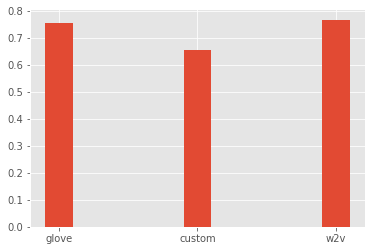

In [0]:
glove_acc = history_glove.history['val_acc'][-1]
custom_acc = history_custom.history['val_acc'][-1]
w2v_acc = history_w2v.history['val_acc'][-1]
plt.bar(np.array(['glove', 'custom', 'w2v']), np.array([glove_acc, custom_acc, w2v_acc]), width = 0.2)

In [0]:
def plot_model_details(data, data_type):
  fig, (ax1, ax2) = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (10, 5))
  acc = data['acc']
  val_acc = data['val_acc']
  loss = data['loss']
  val_loss = data['val_loss']
  epochs = range(1, len(acc) + 1)
  
  ax1.plot(epochs, acc, 'b', label = 'accuracy')
  ax1.plot(epochs, val_acc, 'b', label = 'validation accuracy', color = 'red')
  ax1.legend()
  ax2.plot(epochs, loss, 'b', label = 'loss')
  ax2.plot(epochs, val_loss, 'b', label = 'validation loss', color = 'red')
  ax2.legend()
  fig.suptitle(data_type)

The plots:


*   Plot of Validation Accuracy & Training Accuracy
*   Plot of Validation Loss & Training Loss



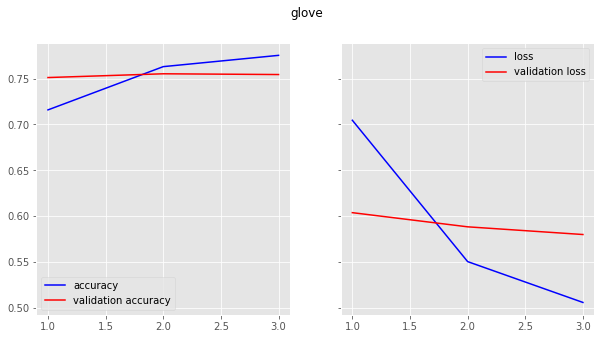

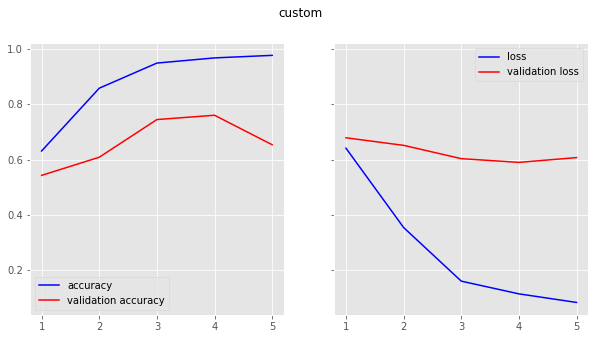

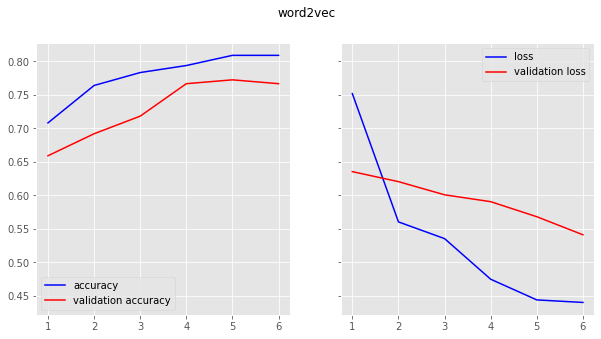

In [0]:
data_glove = history_glove.history
data_custom = history_custom.history
data_w2v = history_w2v.history
plot_model_details(data_glove, 'glove')
plot_model_details(data_custom, 'custom')
plot_model_details(data_w2v, 'word2vec')